## Homework

**Goal**: Create regression model to predict housing prices (column 'median_house_value'). <br>
**Data**: `wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv`

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

In [3]:
cols = ["latitude", 
        "longitude", 
        "housing_median_age", 
        "total_rooms", 
        "total_bedrooms", 
        "population", 
        "households",
        "median_income",
        "median_house_value",
        "ocean_proximity"]

In [4]:
df = df[cols].copy()
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# Fill NAs with 0
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [6]:
df.isna().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
# Apply the log tranform to median_house_value
df.median_house_value = df.median_house_value.apply(np.log1p)

In [8]:
def three_way_splitter(df, target, columns, train_size, val_size, test_size, random_state = 1):
    features = [col for col in columns if col != target]
    X_train_full, X_test, y_train_full, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size/(test_size+train_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test, X_train_full, y_train_full

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test, X_train_full, y_train_full = three_way_splitter(df, 'median_house_value', cols, 0.6, 0.2, 0.2, 1)

In [10]:
print(X_train.shape[0] + X_test.shape[0] + X_val.shape[0], df.shape[0])

20640 20640


In [11]:
dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient="records")
val_dict = X_val.to_dict(orient="records")
test_dict = X_test.to_dict(orient="records")

X_train = dv.fit_transform(train_dict)
#X_test = dv.fit_transform(test_dict)

In [12]:
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND` **<- Answer**
* `total_rooms`
* `latitude`
* `population`

In [37]:
X_train

array([[ 578.  ,   19.  ,   34.63, ..., 1677.  ,  606.  , 3562.  ],
       [  50.  ,   10.  ,   34.69, ...,  108.  ,  102.  ,  337.  ],
       [ 462.  ,   27.  ,   33.78, ..., 1723.  ,  491.  , 1672.  ],
       ...,
       [ 854.  ,   18.  ,   33.9 , ..., 2276.  ,  922.  , 3380.  ],
       [ 415.  ,   41.  ,   36.78, ..., 1129.  ,  462.  , 2227.  ],
       [ 589.  ,    9.  ,   34.02, ..., 2280.  ,  587.  , 4265.  ]])

In [33]:
model = DecisionTreeRegressor(max_depth=1)

In [34]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [35]:
print(export_text(model, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



C:\Users\Kawba\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Answer:** Ocean Proximity INLAND is used for splitting the data.

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* **0.25** **<- Answer**
* 0.55
* 0.85

In [40]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [41]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [46]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2457383433183843

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 150 **<- Answer**

In [68]:
def experimentor(value_list,X_train, y_train, X_val, y_val, random_state=1):
    scores = []
    for n in tqdm(value_list):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((n, score))
    scores_df =pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])
    graph = plt.plot(scores_df.n_estimators, scores_df["RMSE"])
    return scores_df, graph

  0%|          | 0/20 [00:00<?, ?it/s]

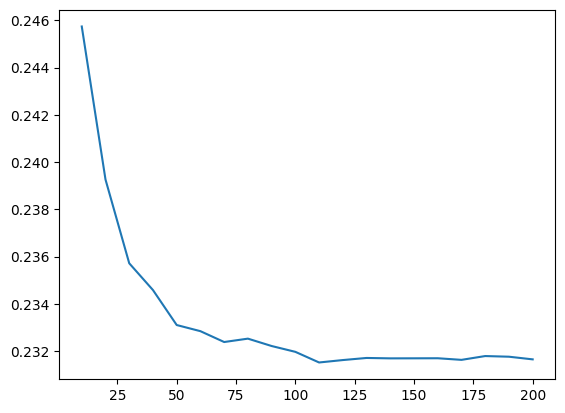

In [73]:
value_list = range(10, 201, 10)
scores_df, _ = experimentor(value_list,X_train, y_train, X_val, y_val, random_state=1)

In [75]:
scores_df.sort_values(by=['RMSE'], ascending=False)

,n_estimators,RMSE
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104
5,60,0.232843
7,80,0.232527
6,70,0.232384
8,90,0.232215
9,100,0.231968


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25 **<- Answer**

In [85]:
def experimentor(estimators, max_depth, X_train, y_train, X_val, y_val, random_state=1):
    scores = []
    for d in max_depth:
        for n in tqdm(estimators):
            rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
            rf.fit(X_train,y_train)
            y_pred = rf.predict(X_val)
            score = np.sqrt(mean_squared_error(y_val, y_pred))
            scores.append((n, d, score))
    scores_df =pd.DataFrame(scores, columns=['n_estimators','max_depth','RMSE'])
    return scores_df

In [86]:
max_depth = [10, 15, 20, 25]
scores_df = experimentor(value_list, max_depth,X_train, y_train, X_val, y_val, random_state=1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [87]:
scores_df

,n_estimators,max_depth,RMSE
0,10,10,0.255042
1,20,10,0.252784
2,30,10,0.251647
3,40,10,0.251062
4,50,10,0.250192
...,...,...,...
75,160,25,0.231484
76,170,25,0.231440
77,180,25,0.231598
78,190,25,0.231603


In [134]:
print(f'depth corresponding to lowest RMSE is {scores_df[scores_df.RMSE == scores_df.RMSE.min()]["max_depth"].iloc[-1]}')

depth corresponding to lowest RMSE is 25


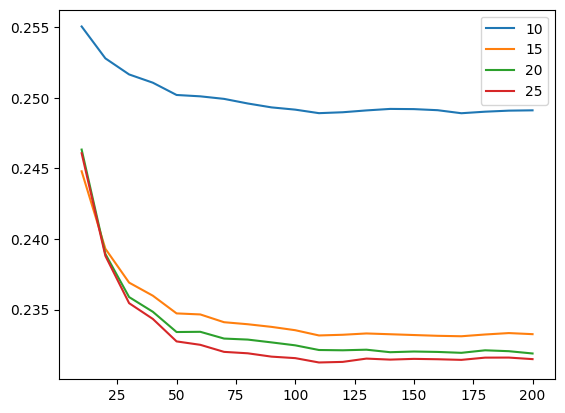

In [92]:
for d in max_depth:
    df_subset = scores_df[scores_df.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.RMSE, label=d)
    plt.legend()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	**<- Answer**
* `total_bedrooms`
* `longitude`


In [135]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

In [136]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [140]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = dv.get_feature_names()
feature_importance['importance'] = rf.feature_importances_
feature_importance.sort_values(by='importance', ascending=False)

C:\Users\Kawba\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3 **<- Answer**
* 0.1
* Both gives same

In [141]:
# Install XGBoost
!pip install xgboost

In [15]:
import xgboost as xgb

In [18]:
# Create DMatrix for train and validation
features_names =['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_1H_OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR_BAY',
 'ocean_proximity_NEAR_OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_names)

In [19]:
# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [26]:
# Train a model with these parameters for 100 rounds
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=4, evals=watchlist)

[0]	train-rmse:8.12733	val-rmse:8.13245
[4]	train-rmse:1.97834	val-rmse:1.98175
[8]	train-rmse:0.54190	val-rmse:0.55047
[12]	train-rmse:0.27095	val-rmse:0.28865
[16]	train-rmse:0.22630	val-rmse:0.25229
[20]	train-rmse:0.21580	val-rmse:0.24624
[24]	train-rmse:0.20703	val-rmse:0.24252
[28]	train-rmse:0.19810	val-rmse:0.23843
[32]	train-rmse:0.19126	val-rmse:0.23686
[36]	train-rmse:0.18486	val-rmse:0.23539
[40]	train-rmse:0.17983	val-rmse:0.23419
[44]	train-rmse:0.17568	val-rmse:0.23317
[48]	train-rmse:0.17139	val-rmse:0.23142
[52]	train-rmse:0.16788	val-rmse:0.23074
[56]	train-rmse:0.16433	val-rmse:0.23006
[60]	train-rmse:0.16177	val-rmse:0.22950
[64]	train-rmse:0.15854	val-rmse:0.22878
[68]	train-rmse:0.15446	val-rmse:0.22825
[72]	train-rmse:0.15212	val-rmse:0.22773
[76]	train-rmse:0.14872	val-rmse:0.22705
[80]	train-rmse:0.14564	val-rmse:0.22611
[84]	train-rmse:0.14244	val-rmse:0.22598
[88]	train-rmse:0.13997	val-rmse:0.22641
[92]	train-rmse:0.13794	val-rmse:0.22619
[96]	train-rmse:0.1

In [25]:
# change `eta` from `0.3` to `0.1`
xgb_params2 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model2 = xgb.train(xgb_params2, dtrain, num_boost_round=100, verbose_eval=4, evals=watchlist)

[0]	train-rmse:10.44372	val-rmse:10.44938
[4]	train-rmse:6.85878	val-rmse:6.86368
[8]	train-rmse:4.50846	val-rmse:4.51264
[12]	train-rmse:2.96894	val-rmse:2.97284
[16]	train-rmse:1.96214	val-rmse:1.96662
[20]	train-rmse:1.30499	val-rmse:1.31054
[24]	train-rmse:0.87914	val-rmse:0.88576
[28]	train-rmse:0.60723	val-rmse:0.61618
[32]	train-rmse:0.43732	val-rmse:0.44960
[36]	train-rmse:0.33733	val-rmse:0.35398
[40]	train-rmse:0.27984	val-rmse:0.30053
[44]	train-rmse:0.24897	val-rmse:0.27269
[48]	train-rmse:0.23170	val-rmse:0.25803
[52]	train-rmse:0.22167	val-rmse:0.24976
[56]	train-rmse:0.21568	val-rmse:0.24560
[60]	train-rmse:0.21035	val-rmse:0.24189
[64]	train-rmse:0.20723	val-rmse:0.24036
[68]	train-rmse:0.20302	val-rmse:0.23798
[72]	train-rmse:0.19928	val-rmse:0.23587
[76]	train-rmse:0.19636	val-rmse:0.23491
[80]	train-rmse:0.19384	val-rmse:0.23398
[84]	train-rmse:0.19129	val-rmse:0.23289
[88]	train-rmse:0.18903	val-rmse:0.23228
[92]	train-rmse:0.18691	val-rmse:0.23162
[96]	train-rmse:0